# Preprocessing

---
## Imports

In [26]:
import sys

import pandas as pd
from sklearn.model_selection import train_test_split

sys.path.append('../')

from utils.duplicates import remove_rows, get_duplicates_to_delete

In [27]:
df = pd.read_csv('../data/processed/csv/df.csv')
duplicates = pd.read_csv('../data/processed/csv/duplicates.csv')

--- 
## Remove duplicates

### Automatically delete:
- For each duplicate group, delete all but one rows marked as "Duplicate" for each "Style".
- Outputs "df_no_dup".

In [28]:
duplicates_to_delete = get_duplicates_to_delete(duplicates)
df_no_dup = remove_rows(df, duplicates_to_delete)
df_no_dup

Identifying rows to delete...


100%|██████████| 5684/5684 [00:02<00:00, 2408.43it/s]

Removing rows...


,Path,Type,Width,Height,Ratio,Mode,Class,Style
0,tables/Eclectic/4029eclectic-side-tables-and-e...,jpg,350,350,1.0,RGB,tables,Eclectic
1,tables/Eclectic/4107eclectic-nightstands-and-b...,jpg,350,350,1.0,RGB,tables,Eclectic
2,tables/Eclectic/3885eclectic-side-tables-and-e...,jpg,350,350,1.0,RGB,tables,Eclectic
3,tables/Eclectic/4040eclectic-side-tables-and-e...,jpg,350,350,1.0,RGB,tables,Eclectic
4,tables/Eclectic/4171eclectic-coffee-tables.jpg,jpg,350,350,1.0,RGB,tables,Eclectic
...,...,...,...,...,...,...,...,...
84791,beds/Asian/3166asian-daybeds.jpg,jpg,224,224,1.0,RGB,beds,Asian
84792,beds/Asian/7733asian-panel-beds.jpg,jpg,224,224,1.0,RGB,beds,Asian
84793,beds/Asian/20802asian-platform-beds.jpg,jpg,350,350,1.0,RGB,beds,Asian
84794,beds/Asian/7850asian-platform-beds.jpg,jpg,224,224,1.0,RGB,beds,Asian


### Manually delete:
- Any rows marked as "Inspect" that belongs in the wrong "Class".
- Overwrite "df", as this DataFrame will continue to be used for further preprocessing.

In [29]:
inspects = duplicates[duplicates['Duplicate_Type'] == 'Inspect']
inspects

,Group,Duplicate_Type,Path,Type,Width,Height,Ratio,Mode,Class,Style,Hash
90,41,Inspect,tables/Craftsman/28467craftsman-dressers.jpg,jpg,350,350,1.0,RGB,tables,Craftsman,fbea6ebbd105a451cd78b1ccae23cb8492f195ae1d2312...
91,41,Inspect,beds/Craftsman/4866craftsman-bed.jpg,jpg,350,350,1.0,RGB,beds,Craftsman,fbea6ebbd105a451cd78b1ccae23cb8492f195ae1d2312...
153,72,Inspect,tables/Industrial/37555industrial-entertainmen...,jpg,350,350,1.0,RGB,tables,Industrial,d6aa7d5a82ad6a0068540af5ad5596af9055d02b93f41f...
154,72,Inspect,dressers/Industrial/dresser3452345.jpg,jpg,350,350,1.0,RGB,dressers,Industrial,d6aa7d5a82ad6a0068540af5ad5596af9055d02b93f41f...
205,98,Inspect,dressers/Farmhouse/34120farmhouse-buffets-and-...,jpg,350,350,1.0,RGB,dressers,Farmhouse,8bfa4afe3c256aadd100341fc042955a70b5cb41947de6...
206,98,Inspect,tables/Farmhouse/28763farmhouse-console-tables...,jpg,350,350,1.0,RGB,tables,Farmhouse,8bfa4afe3c256aadd100341fc042955a70b5cb41947de6...
227,109,Inspect,tables/Modern/10363modern-nightstands-and-beds...,jpg,350,350,1.0,RGB,tables,Modern,b3980ddb3c66d39bd098f3a70c182c66c39ff068c99734...
228,109,Inspect,lamps/Contemporary/4023contemporary-table-lamp...,jpg,350,350,1.0,RGB,lamps,Contemporary,b3980ddb3c66d39bd098f3a70c182c66c39ff068c99734...
235,113,Inspect,dressers/Modern/2146modern-dressers.jpg,jpg,350,350,1.0,RGB,dressers,Modern,f3bbad52dccc13b9cc659725921158ce2dd594a5931146...
236,113,Inspect,tables/Modern/11484modern-dressers.jpg,jpg,350,350,1.0,RGB,tables,Modern,f3bbad52dccc13b9cc659725921158ce2dd594a5931146...


In [30]:
total_inspect_groups = inspects["Group"].nunique(dropna=False)

In [31]:
# inspects_rows_to_delete = [91, 154, 205, 227, 235, 277, 280, 281, 287, 290, 299, 310, 318, 323, 325] # Delete one of each pair
inspects_rows_to_delete = [91,
                           205]  # Only delete very different class ("tables" and "beds"). Similar classes are kept ("chairs" and "sofas")

In [32]:
inspect_review = inspects.copy()
inspect_review["Duplicate_Type"] = "Keep"
# inspect_review.loc[inspects_rows_to_delete, "Duplicate_Type"] = "DELETE"

In [33]:
# visualize_duplicates(inspect_review, total_inspect_groups)

In [34]:
inspects_to_delete = inspect_review[inspect_review["Duplicate_Type"] == "DELETE"]
inspects_to_delete

,Group,Duplicate_Type,Path,Type,Width,Height,Ratio,Mode,Class,Style,Hash


In [35]:
df = remove_rows(df, inspects_to_delete)
df

Removing rows...


,Path,Type,Width,Height,Ratio,Mode,Class,Style
0,tables/Eclectic/4029eclectic-side-tables-and-e...,jpg,350,350,1.0,RGB,tables,Eclectic
1,tables/Eclectic/4107eclectic-nightstands-and-b...,jpg,350,350,1.0,RGB,tables,Eclectic
2,tables/Eclectic/3885eclectic-side-tables-and-e...,jpg,350,350,1.0,RGB,tables,Eclectic
3,tables/Eclectic/4040eclectic-side-tables-and-e...,jpg,350,350,1.0,RGB,tables,Eclectic
4,tables/Eclectic/4171eclectic-coffee-tables.jpg,jpg,350,350,1.0,RGB,tables,Eclectic
...,...,...,...,...,...,...,...,...
90079,beds/Asian/3166asian-daybeds.jpg,jpg,224,224,1.0,RGB,beds,Asian
90080,beds/Asian/7733asian-panel-beds.jpg,jpg,224,224,1.0,RGB,beds,Asian
90081,beds/Asian/20802asian-platform-beds.jpg,jpg,350,350,1.0,RGB,beds,Asian
90082,beds/Asian/7850asian-platform-beds.jpg,jpg,224,224,1.0,RGB,beds,Asian


---
## Prepare DataFrame

In [36]:
import pandas as pd

# Assuming you have the original "df" and "duplicates_to_delete" DataFrames

# Merge the two DataFrames based on the "Path" column
merged_df = pd.merge(df, duplicates_to_delete[['Path']], on='Path', how='left', indicator=True)

# Create the "Duplicate_Type" column based on the merge indicator
merged_df['Duplicate_Type'] = merged_df['_merge'].map({'both': "Duplicate", 'left_only': "Unique"})

# Drop the merge indicator column
merged_df = merged_df.drop('_merge', axis=1)

# Update the original "df" with the new "Duplicate_Type" column
df = merged_df

In [37]:
df

,Path,Type,Width,Height,Ratio,Mode,Class,Style,Duplicate_Type
0,tables/Eclectic/4029eclectic-side-tables-and-e...,jpg,350,350,1.0,RGB,tables,Eclectic,Unique
1,tables/Eclectic/4107eclectic-nightstands-and-b...,jpg,350,350,1.0,RGB,tables,Eclectic,Unique
2,tables/Eclectic/3885eclectic-side-tables-and-e...,jpg,350,350,1.0,RGB,tables,Eclectic,Unique
3,tables/Eclectic/4040eclectic-side-tables-and-e...,jpg,350,350,1.0,RGB,tables,Eclectic,Unique
4,tables/Eclectic/4171eclectic-coffee-tables.jpg,jpg,350,350,1.0,RGB,tables,Eclectic,Unique
...,...,...,...,...,...,...,...,...,...
90079,beds/Asian/3166asian-daybeds.jpg,jpg,224,224,1.0,RGB,beds,Asian,Unique
90080,beds/Asian/7733asian-panel-beds.jpg,jpg,224,224,1.0,RGB,beds,Asian,Unique
90081,beds/Asian/20802asian-platform-beds.jpg,jpg,350,350,1.0,RGB,beds,Asian,Unique
90082,beds/Asian/7850asian-platform-beds.jpg,jpg,224,224,1.0,RGB,beds,Asian,Unique


---
## Split (train, validation, test)

### Prepare target and training

In [38]:
train_data = df.copy()

### Splitting

In [39]:
train_X, test_X = train_test_split(
    train_data,
    test_size=0.2,
    random_state=42
)
train_X, val_X = train_test_split(
    train_X,
    test_size=0.25,
    random_state=42
)

In [40]:
train_X

,Path,Type,Width,Height,Ratio,Mode,Class,Style,Duplicate_Type
86444,beds/Traditional/6052traditional-panel-beds.jpg,jpg,224,224,1.0,RGB,beds,Traditional,Unique
34246,lamps/Traditional/13841traditional-table-lamps...,jpg,350,350,1.0,RGB,lamps,Traditional,Unique
75698,dressers/Midcentury/2573midcentury-dressers.jpg,jpg,350,350,1.0,RGB,dressers,Midcentury,Unique
61455,chairs/Transitional/24948transitional-armchair...,jpg,350,350,1.0,RGB,chairs,Transitional,Unique
54290,chairs/Midcentury/19121midcentury-dining-chair...,jpg,350,350,1.0,RGB,chairs,Midcentury,Unique
...,...,...,...,...,...,...,...,...,...
22949,lamps/Midcentury/7601midcentury-floor-lamps.jpg,jpg,350,350,1.0,RGB,lamps,Midcentury,Unique
26202,lamps/Victorian/29215victorian-pool-table-ligh...,jpg,350,350,1.0,RGB,lamps,Victorian,Unique
63372,chairs/Traditional/12162traditional-recliner-c...,jpg,350,350,1.0,RGB,chairs,Traditional,Unique
10575,tables/Beach/22508beach-style-coffee-tables.jpg,jpg,350,350,1.0,RGB,tables,Beach,Unique


---
## Rescaling & Normalization
Note: Using Tensorflow for quick normalization and rescaling. In 'utils/tensorflow_preprocessing.py' file, there is a functions to normalize and rescale the each image in the dataset.

In [41]:
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder

AUTOTUNE = tf.data.experimental.AUTOTUNE

In [42]:
def process_image_from_path(image_path, img_height, img_width, to_augment):
    # Read image
    img = tf.io.read_file(image_path)

    # Decode to RGB
    img = tf.io.decode_jpeg(img, channels=3)

    # Resize
    img = tf.image.resize(img, [img_height, img_width])

    # Augment
    is_duplicate = tf.equal(to_augment, "Duplicate")

    def augment_image_tf(img):
        # Flip horizontally
        img = tf.image.random_flip_left_right(img)
        # Adjust brightness
        img = tf.image.random_brightness(img, max_delta=0.2)
        # Adjust contrast
        img = tf.image.random_contrast(img, lower=0.8, upper=1.2)

        return img

    img = tf.cond(is_duplicate, lambda: augment_image_tf(img), lambda: img)

    # Rescale
    rescaling_layer = tf.keras.layers.Rescaling(scale=1. / 255)
    img = rescaling_layer(img) 
    # Commented out right now cause it makes all the output image black, which I'm not sure is supposed to happen

    return img

In [43]:
def prepare_image_dataset(df, img_height, img_width, batch_size, base_path='../data/raw/Furniture_Data',
                          label_encoder=None):
    prepared_df = df.assign(Path=df['Path'].apply(lambda path: base_path + "/" + path))

    # REMOVE (shorten the df for faster testing)
    # prepared_df = prepared_df.sample(frac=0.05, random_state=42)

    # Perform label encoding on the class labels
    if label_encoder is None:
        label_encoder = LabelEncoder()
        prepared_df['Class_Encoded'] = label_encoder.fit_transform(prepared_df['Class'])
    else:
        prepared_df['Class_Encoded'] = label_encoder.transform(prepared_df['Class'])

    dataset = tf.data.Dataset.from_tensor_slices(
        (prepared_df['Path'].values,
         prepared_df["Duplicate_Type"].values,
         prepared_df['Class_Encoded'].values)
    )

    image_ds = dataset.map(lambda path, duplicate_type, class_label:
                           (
                               process_image_from_path(image_path=path,
                                                       img_height=img_height,
                                                       img_width=img_width,
                                                       to_augment=duplicate_type),
                               class_label
                           ),
                           num_parallel_calls=tf.data.AUTOTUNE
                           )

    image_ds = image_ds.batch(batch_size)

    return image_ds, label_encoder

In [44]:
train_dataset, label_encoder = prepare_image_dataset(train_X, img_height=256, img_width=256, batch_size=32)
val_dataset, _ = prepare_image_dataset(val_X, img_height=256, img_width=256, batch_size=32, label_encoder=label_encoder)
test_dataset, _ = prepare_image_dataset(test_X, img_height=256, img_width=256, batch_size=32,
                                        label_encoder=label_encoder)

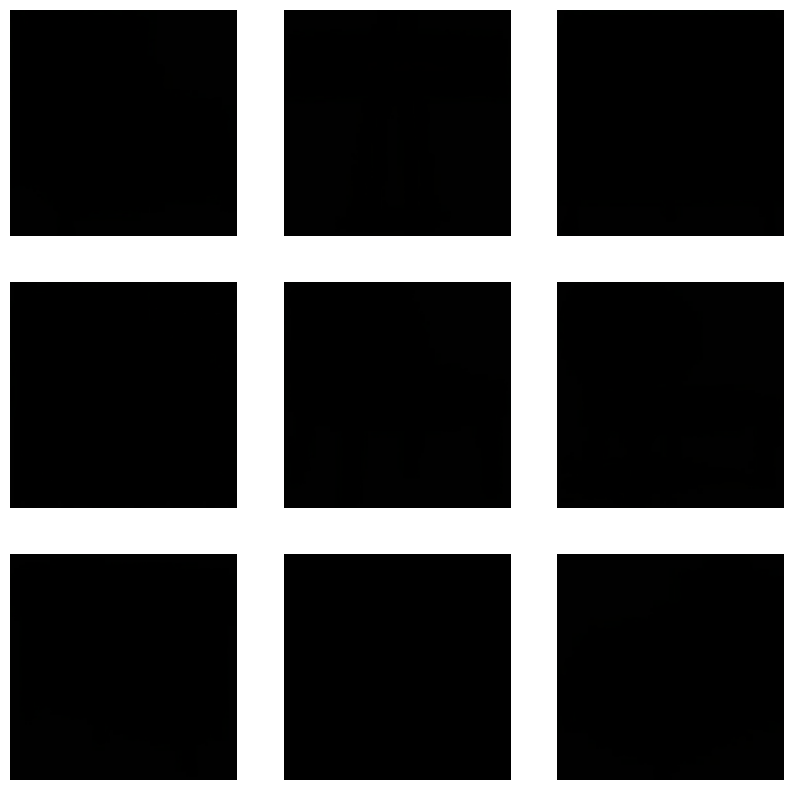

In [45]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        # plt.title(class_names[labels[i]])
        plt.axis("off")

# DON'T WORRY if the images here are black. Comment out the rescaling part in process_image_from_path() to see the images.

---
## Test

In [46]:
from tensorflow.keras import layers, models, Input
from tensorflow.keras.callbacks import ProgbarLogger

In [47]:
model = models.Sequential([
    Input(shape=(256, 256, 3)),
    layers.Conv2D(4, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(8, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(16, (3, 3), activation='relu'),
    layers.GlobalMaxPooling2D(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5, seed=21),
    layers.Dense(128, activation='relu'),
    layers.Dropout(1, seed=42),
    layers.Dense(128, activation='sigmoid'),
    layers.Dense(6, activation='softmax')
])

In [48]:
# Step 3: Compile the Model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [49]:
# Step 4: Train the Model
epochs = 10
history = model.fit(
    train_dataset,
    epochs=epochs,
    batch_size=32,
    callbacks=[ProgbarLogger()]
)

Epoch 1/10
1690/1690 [==============================] - 55s 33ms/sample - loss: 1.2754 - accuracy: 0.5064
Epoch 2/10
1690/1690 [==============================] - 53s 31ms/sample - loss: 1.0341 - accuracy: 0.6093
Epoch 3/10
1690/1690 [==============================] - 52s 31ms/sample - loss: 0.9429 - accuracy: 0.6485
Epoch 4/10
1690/1690 [==============================] - 55s 33ms/sample - loss: 0.8903 - accuracy: 0.6679
Epoch 5/10
1690/1690 [==============================] - 52s 31ms/sample - loss: 0.8490 - accuracy: 0.6842
Epoch 6/10
1690/1690 [==============================] - 52s 31ms/sample - loss: 0.8212 - accuracy: 0.6937
Epoch 7/10
1690/1690 [==============================] - 53s 31ms/sample - loss: 0.8037 - accuracy: 0.7004
Epoch 8/10
1690/1690 [==============================] - 52s 31ms/sample - loss: 0.7897 - accuracy: 0.7051
Epoch 9/10
1690/1690 [==============================] - 53s 31ms/sample - loss: 0.7804 - accuracy: 0.7082
Epoch 10/10
1690/1690 [=======================

In [50]:
# Step 5: Evaluate the Model
test_loss, test_accuracy = model.evaluate(test_dataset, steps=len(test_dataset))
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

564/564 [==============================] - 10s 18ms/step - loss: 0.7793 - accuracy: 0.6971
Test Loss: 0.7793
Test Accuracy: 0.6971


In [51]:
print(train_dataset.element_spec)

(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))


In [52]:
print(test_dataset.element_spec)

(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))
